In [1]:
# %conda install -y matplotlib

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import PIL

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"number of gpus: {torch.cuda.device_count()}")
# device = "cpu"
print(device)

batch_size = 32

number of gpus: 1
cuda:0


In [7]:
#Setting up Kaggle API
 #Connecting to kaggle API
import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

# base_dir = '/home/azureuser/'
base_dir = "/home/fsuser/"
kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir)
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

# open file at ~/.kaggle/kaggle.json and print it
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print(f.read())

base_path = "/home/fsuser/Deep-Learning/"
data_path = base_path+"downloaded-data/"
if not os.path.exists(data_path): os.mkdir(data_path)
!kaggle config set -n path -v {data_path}

base_dir: /home/fsuser/
kaggle_dir: /home/fsuser/.kaggle
{"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}
- path is now set to: /home/fsuser/Deep-Learning/downloaded-data/


In [12]:
! kaggle competitions download vesuvius-challenge-ink-detection

100%|█████████████████████████████████████▉| 20.6G/20.6G [06:58<00:00, 49.1MB/s]
100%|██████████████████████████████████████| 20.6G/20.6G [06:58<00:00, 52.9MB/s]


In [13]:
!ls /home/fsuser/Deep-Learning/downloaded-data/competitions/vesuvius-challenge-ink-detection

vesuvius-challenge-ink-detection.zip


In [14]:
#unzip file simpsons-faces.zip
with zipfile.ZipFile(data_path+"competitions/vesuvius-challenge-ink-detection/vesuvius-challenge-ink-detection.zip","r") as zip_ref:
    zip_ref.extractall(data_path)

In [23]:
!ls /home/fsuser/Deep-Learning/downloaded-data/train
!ls /home/fsuser/Deep-Learning/downloaded-data/train/1
!ls /home/fsuser/Deep-Learning/downloaded-data/train/1/surface_volume

1  2  3
inklabels.png  inklabels_rle.csv  ir.png  mask.png  surface_volume
00.tif	07.tif	14.tif	21.tif	28.tif	35.tif	42.tif	49.tif	56.tif	63.tif
01.tif	08.tif	15.tif	22.tif	29.tif	36.tif	43.tif	50.tif	57.tif	64.tif
02.tif	09.tif	16.tif	23.tif	30.tif	37.tif	44.tif	51.tif	58.tif
03.tif	10.tif	17.tif	24.tif	31.tif	38.tif	45.tif	52.tif	59.tif
04.tif	11.tif	18.tif	25.tif	32.tif	39.tif	46.tif	53.tif	60.tif
05.tif	12.tif	19.tif	26.tif	33.tif	40.tif	47.tif	54.tif	61.tif
06.tif	13.tif	20.tif	27.tif	34.tif	41.tif	48.tif	55.tif	62.tif


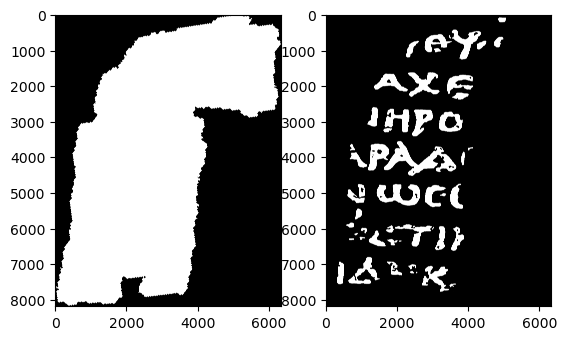

/home/fsuser/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


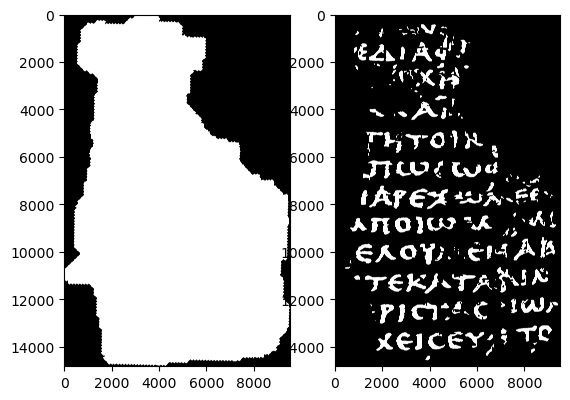

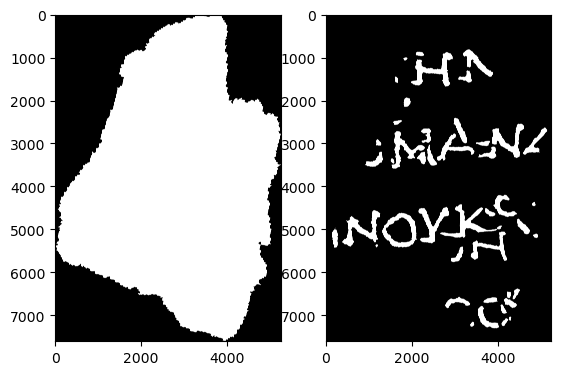

torch.Size([8181, 6330]) torch.Size([8181, 6330])
torch.Size([14830, 9506]) torch.Size([14830, 9506])
torch.Size([7606, 5249]) torch.Size([7606, 5249])


In [33]:
def load_mask_label(mask_filepath=None, label_filepath=None, display = True):
  mask = False if mask_filepath is None else torch.from_numpy(np.array(PIL.Image.open(mask_filepath).convert('1')))
  label = False if label_filepath is None else torch.from_numpy(np.array(PIL.Image.open(label_filepath))).float()
  if display:
    if label_filepath is None:
      plt.imshow(mask, cmap = 'gray')
      plt.show()
    else:
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(mask, cmap = 'gray')
      ax2.imshow(label, cmap = 'gray')
      plt.show()
  return mask, label

masks, labels = [], []
for i in range(1, 4):
    mask, label = load_mask_label(data_path+f"train/{i}/mask.png", data_path+f"train/{i}/inklabels.png")
    masks.append(mask)
    labels.append(label)

for mask, label in zip(masks, labels):
    print(mask.shape, label.shape)

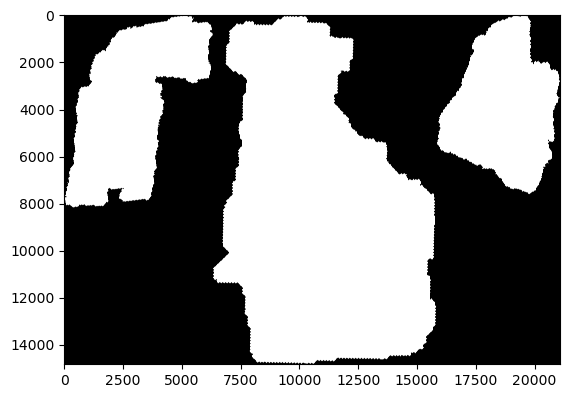

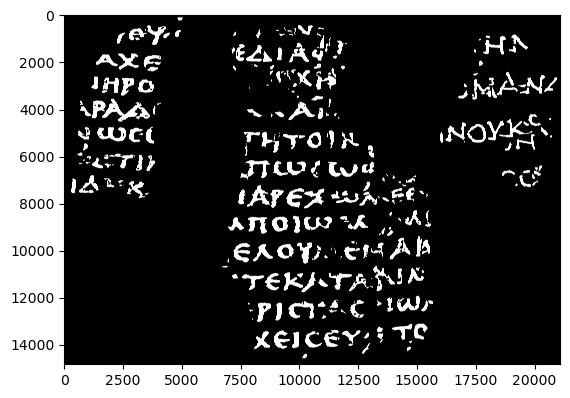

In [51]:
height, _ = masks[1].shape
height

def concat_3_images(images):
    """Returns a single image with the three images concatenated horizontally.
    Args:
        images(list of PIL/numpy images):  --The images to concatenate.
    """
    pad_1 = torch.zeros((height-images[0].shape[0],images[0].shape[1]))
    img_1_pad = torch.cat((images[0], pad_1), dim=0)
    pad_2 = torch.zeros((height-images[2].shape[0],images[2].shape[1]))
    img_2_pad = torch.cat((images[2], pad_2), dim=0)
    full_img_pad = torch.cat((img_1_pad, images[1], img_2_pad), dim=1)
    return full_img_pad

combined_mask = concat_3_images(masks)
plt.imshow(combined_mask, cmap = "gray")
plt.show()
combined_labels = concat_3_images(labels)
plt.imshow(combined_labels, cmap = "gray")
plt.show()

In [ ]:
def generate_image_stack(tif_filepaths, Z_START, Z_DIM, display = True):
  layers_to_use = tif_filepaths[Z_START:Z_START+Z_DIM]
  image_stack = [np.array(PIL.Image.open(filepath), dtype=np.float32)/65535.0 for filepath in tqdm(layers_to_use)]
  if display:
    fig, axes = plt.subplots(1, len(image_stack), figsize=(15, 3))
    for image, ax in zip(image_stack, axes):
        ax.imshow(np.array(PIL.Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    plt.show()
  image_stack = torch.stack([torch.from_numpy(image) for image in image_stack], dim=0).to(device)
  print(f"image_stack shape: {image_stack.shape}")
  return image_stack

In [ ]:
### Hyperparameters
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction

In [29]:
masks[0].shape

torch.Size([8181, 6330])